In [2]:
from unet import u_net


In [37]:
import gdal
from gdalconst import * 

img_filename_16bandR = 'datasets/three_band/6030_0_0.tif'
img_filename_16bandG = 'datasets/three_band/6030_0_1.tif'
img_filename_16bandB = 'datasets/three_band/6030_0_2.tif'

datasetA = gdal.Open(img_filename_16bandR, GA_ReadOnly)
datasetM = gdal.Open(img_filename_16bandG, GA_ReadOnly)
datasetP = gdal.Open(img_filename_16bandB, GA_ReadOnly)



print('Size is ',datasetA.RasterXSize,'x',datasetA.RasterYSize,
 'x',datasetA.RasterCount)
print('Size is ',datasetM.RasterXSize,'x',datasetM.RasterYSize,
 'x',datasetM.RasterCount)
print('Size is ',datasetP.RasterXSize,'x',datasetP.RasterYSize, \
 'x',datasetP.RasterCount)

Size is  3403 x 3348 x 3
Size is  3403 x 3348 x 3
Size is  3403 x 3348 x 3


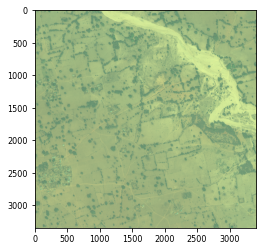

In [45]:
import matplotlib.pyplot as plt
import numpy as np

rb = datasetA.GetRasterBand(1).ReadAsArray()
gb = datasetA.GetRasterBand(2).ReadAsArray()
bb = datasetA.GetRasterBand(3).ReadAsArray()

img = np.dstack((rb, gb, bb))
img = img/img.max()
plt.imshow(img)


# img_array = np.dstack((rb, gb, bb))

# plt.imshow(img_array)

(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x1d7ab7e9c40>)

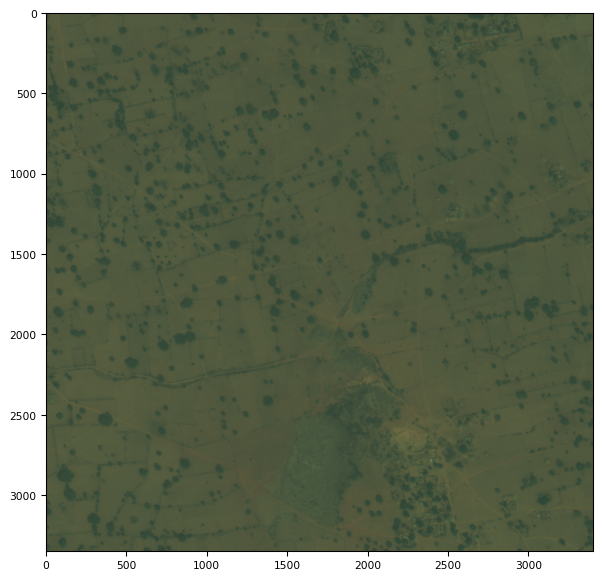

In [49]:
import tifffile as tiff
P = tiff.imread("datasets/three_band/6030_0_4.tif") 
tiff.imshow(P)

In [51]:
import pandas as pd


N_Cls = 10  # Number of Classes
inDir = 'datasets'
DF = pd.read_csv(inDir + '/train_wkt_v4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
ISZ = 160
smooth = 1e-12

def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask

NameError: name 'pd' is not defined

In [ ]:
def load_data(path, prefix="train", size=(224, 224), nb_channels=3, nb_classes):

"""On définit la fonction qui permet de charger les données"""


    files = glob(os.path.join(path, prefix, "jpg", "*.jpg"))
    n_samples = len(files)
    X = np.zeros(shape=(n_samples, size[0], size[1], nb_channels), dtype="float32")
    Y = np.zeros(shape=(n_samples, size[0], size[1], nb_classes), dtype="uint8")
    for i, f in enumerate(files):
        X[i] = resize(imread(f), size, order=1, preserve_range=True)
        f = f.replace("jpg", "lbl")
        f = f.replace(".lbl", ".jpg")
        y = imread(f)
        y[y > 128] = 255
        y[y < 129] = 0
        Y[i,:,:,0] = resize(y, size, order=0, preserve_range=True).astype(int)
    Y[Y > 0] = 1    
    return X, Y

In [ ]:
"""On charge les données en X_train, X_val, X_test"""

path = "datasets/three_band"

X_train, Y_train = load_tissue_segmentation_data(path, prefix="train")
n_train = X_train.shape[0]
X_val, Y_val = load_tissue_segmentation_data(path, prefix="val")
n_val = X_val.shape[0]
X_test, Y_test = load_tissue_segmentation_data(path, prefix="test")
n_test = X_test.shape[0]
print("We have {} training samples, {} validation samples and {} testing samples".format(n_train, n_val, n_test))

In [ ]:
"""Permet d'observer une image, et son masque"""

index = 11  # Index de l'image qu'on souhaite regarder
plt.rcParams['figure.figsize'] = (20.0, 16.0)  #Dimensions de la figure
plt.subplot(1, 2, 1)
plt.imshow(X_test[index, :, :].astype('uint8'))
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(Y_test[index, :, :, 0])
plt.title("Segm")

In [ ]:
#image shape
img_rows = 224
img_cols = 224
img_channels = 3


# architecture params
nb_filters_0 = 16
sigma_noise = 0

# ****  deep learning model
shape = (img_rows, img_cols, img_channels)
model = u_net(shape, nb_filters_0, sigma_noise=sigma_noise)

# ****  train
opt_name = 'adam'  # choices:adadelta; sgd, rmsprop, adagrad, adam, nadam
loss_func = "binary_crossentropy"  # mse, mae, binary_crossentropy, jaccard2_loss
if opt_name == "sgd":
    opt = SGD(lr=0.1)
elif opt_name == "rmsprop":
    opt = RMSprop()
elif opt_name == "adagrad":
    opt = Adagrad()
elif opt_name == "adadelta":
    opt = Adadelta()
elif opt_name == "adam":
    opt = Adam()
elif opt_name == "nadam":
    opt = Nadam()
else:
    raise NameError("Wrong optimizer name")
model.compile(loss=loss_func, optimizer=opt)
print(model.summary())

### Entraînement du modèle

In [ ]:
Y_train = Y_train.astype('float')
Y_val = Y_val.astype('float')

batch_size = 40

nb_epoch = 16

verbose = 1
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    validation_data=(X_val, Y_val),
                    shuffle=True,
                    verbose=verbose)

### Prédiction du modèle

In [ ]:
Y_test_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)
Y_val_pred = model.predict(X_val)

print(jaccard(Y_train,Y_train_pred))
print(jaccard(Y_val,Y_val_pred))
print(jaccard(Y_test,Y_test_pred))

In [64]:
import numpy as np
import matplotlib.pyplot as plt
img_in = np.load('data/x_tmp_10.npy')
img_out = np.load('data/y_tmp_10.npy')

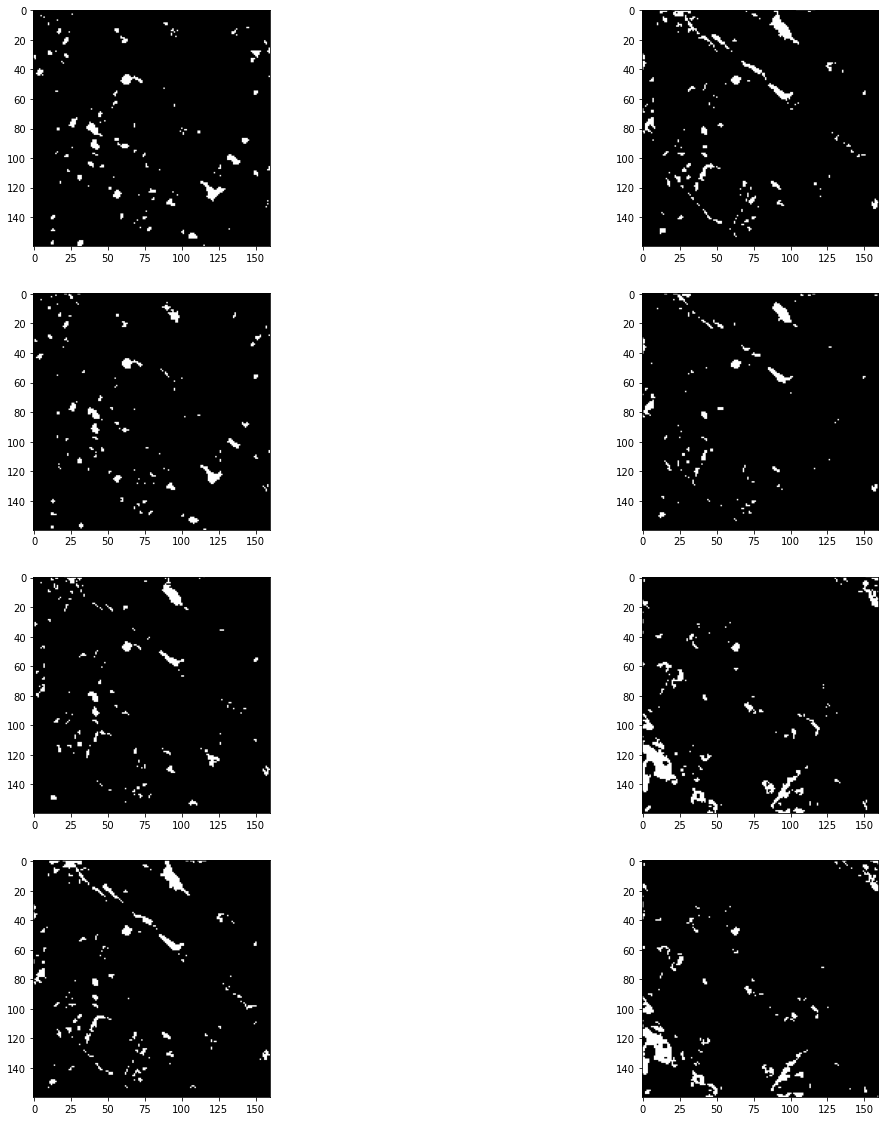

In [70]:
fig1, axs1 = plt.subplots(4, 2, figsize = (20, 20))
for i in range(0, 8):
    axs1[(i)%4][i//4].imshow(img_in[0][:,:,i], cmap = "gray")

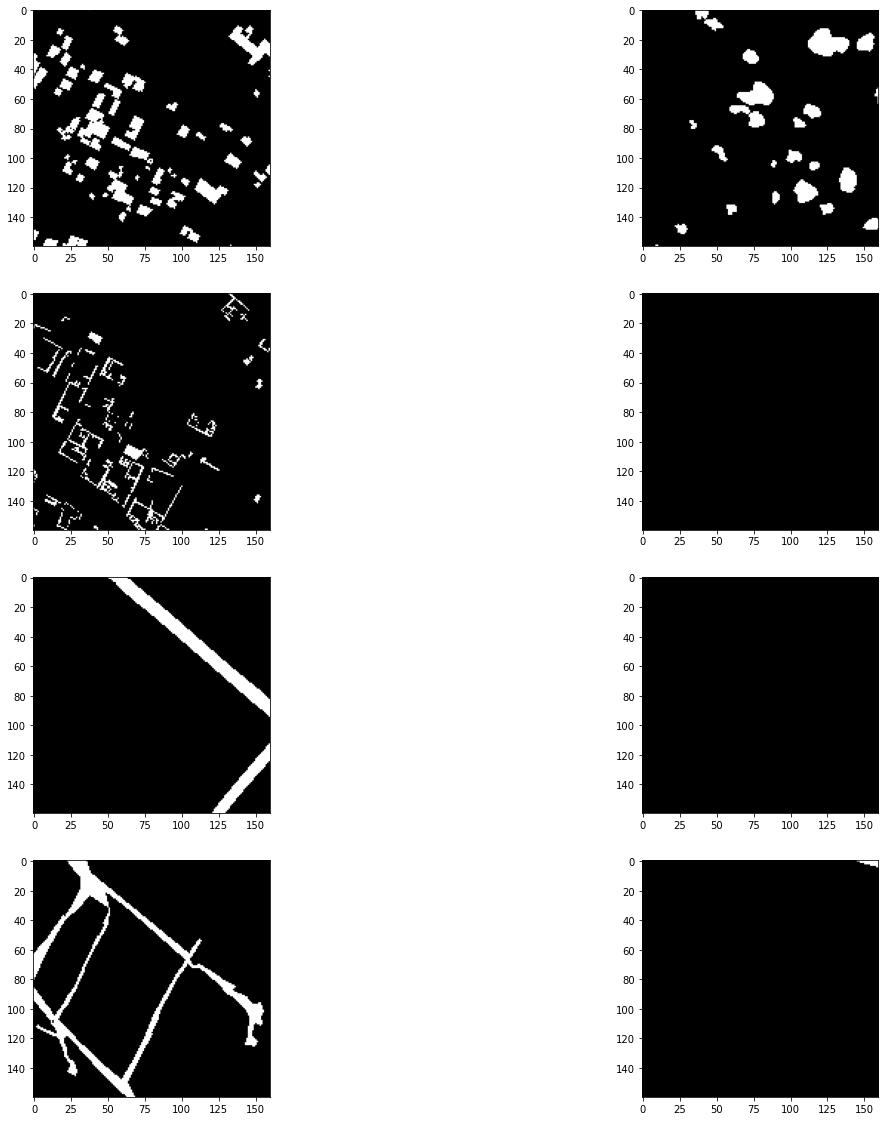

In [69]:
fig2, axs2 = plt.subplots(4, 2, figsize = (20, 20))
for i in range(0, 8):
    axs2[(i)%4][i//4].imshow(img_out[0][:,:,i], cmap = "gray")